In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score,precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from scipy.stats import uniform
from sklearn.metrics import roc_curve, auc
file_path = 'url_dataset.csv'    
data = pd.read_csv(file_path)

In [2]:
data.info(), data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Domain         10000 non-null  object
 1   Have_IP        10000 non-null  int64 
 2   Have_At        10000 non-null  int64 
 3   URL_Length     10000 non-null  int64 
 4   URL_Depth      10000 non-null  int64 
 5   Redirection    10000 non-null  int64 
 6   https_Domain   10000 non-null  int64 
 7   TinyURL        10000 non-null  int64 
 8   Prefix/Suffix  10000 non-null  int64 
 9   DNS_Record     10000 non-null  int64 
 10  Web_Traffic    10000 non-null  int64 
 11  Domain_Age     10000 non-null  int64 
 12  Domain_End     10000 non-null  int64 
 13  iFrame         10000 non-null  int64 
 14  Mouse_Over     10000 non-null  int64 
 15  Right_Click    10000 non-null  int64 
 16  Web_Forwards   10000 non-null  int64 
 17  Label          10000 non-null  int64 
dtypes: int64(17), object(1)
mem

(None,
             Have_IP       Have_At    URL_Length     URL_Depth   Redirection  \
 count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
 mean       0.005500      0.022600      0.773400      3.072000      0.013500   
 std        0.073961      0.148632      0.418653      2.128631      0.115408   
 min        0.000000      0.000000      0.000000      0.000000      0.000000   
 25%        0.000000      0.000000      1.000000      2.000000      0.000000   
 50%        0.000000      0.000000      1.000000      3.000000      0.000000   
 75%        0.000000      0.000000      1.000000      4.000000      0.000000   
 max        1.000000      1.000000      1.000000     20.000000      1.000000   
 
        https_Domain       TinyURL  Prefix/Suffix    DNS_Record   Web_Traffic  \
 count  10000.000000  10000.000000   10000.000000  10000.000000  10000.000000   
 mean       0.000200      0.090300       0.093200      0.100800      0.845700   
 std        0.014141      0.

In [3]:
outliers = {}
for column in data.select_dtypes(include=['int64']).columns:
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outlier_count = ((data[column] < lower_bound) | (data[column] > upper_bound)).sum()
    outliers[column] = outlier_count

outliers

{'Have_IP': 55,
 'Have_At': 226,
 'URL_Length': 2266,
 'URL_Depth': 357,
 'Redirection': 135,
 'https_Domain': 2,
 'TinyURL': 903,
 'Prefix/Suffix': 932,
 'DNS_Record': 1008,
 'Web_Traffic': 1543,
 'Domain_Age': 0,
 'Domain_End': 1901,
 'iFrame': 909,
 'Mouse_Over': 666,
 'Right_Click': 7,
 'Web_Forwards': 1053,
 'Label': 0}

In [4]:
X = data.drop(["Label","Domain"], axis=1)
y = data["Label"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.25)

In [22]:
def plot_roc_curve(classifier, X_test,y_test):
    y_scores = classifier.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test,y_scores)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.4f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()


In [19]:
def plot_confusion_matrix(classifier, confusion_matrix):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,display_labels=classifier.classes_)
    disp.plot()
    plt.show()

In [39]:
#Neural Network 
parameters = {'activation': ['identity', 'logistic', 'tanh', 'relu'], 'solver': ['lbfgs','adam','sgd'], 'hidden_layer_sizes':np.arange(5, 15),'max_iter':[1000,1100,1200,1300,1400],'alpha':uniform(.0001,.01)}
mlp_clf = RandomizedSearchCV(MLPClassifier(), param_distributions=parameters,scoring='accuracy',n_jobs=-1)
mlp_clf.fit(X_train, y_train)
print(mlp_clf.best_params_)

{'activation': 'tanh', 'alpha': 0.0014404468364378885, 'hidden_layer_sizes': 12, 'max_iter': 1400, 'solver': 'adam'}


MLP Accuracy: 0.8484 
MLP Recall 0.7351308485329104 
MLP Precision 0.9537037037037037


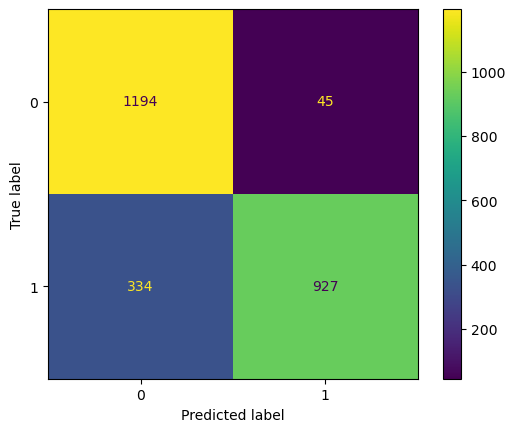

              precision    recall  f1-score   support

           0       0.78      0.96      0.86      1239
           1       0.95      0.74      0.83      1261

    accuracy                           0.85      2500
   macro avg       0.87      0.85      0.85      2500
weighted avg       0.87      0.85      0.85      2500



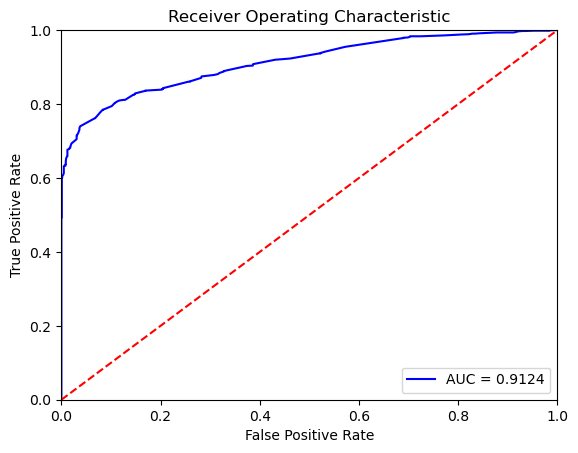

In [41]:
y_pred = mlp_clf.predict(X_test)

mlp_accuracy = accuracy_score(y_test,y_pred)
mlp_recall = recall_score(y_test,y_pred)
mlp_precision = precision_score(y_test,y_pred)

print("MLP Accuracy:",mlp_accuracy,"\nMLP Recall",mlp_recall,"\nMLP Precision",mlp_precision)

mlp_confusion_matrix = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(mlp_clf,mlp_confusion_matrix)

print(classification_report(y_test,y_pred))

plot_roc_curve(mlp_clf,X_test,y_test)

Accuracy: 0.8616


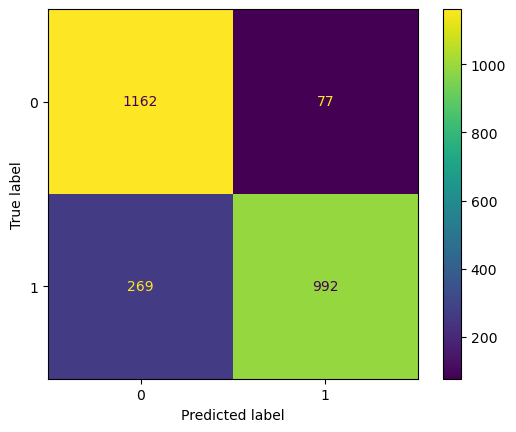


Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.94      0.87      1239
           1       0.93      0.79      0.85      1261

    accuracy                           0.86      2500
   macro avg       0.87      0.86      0.86      2500
weighted avg       0.87      0.86      0.86      2500



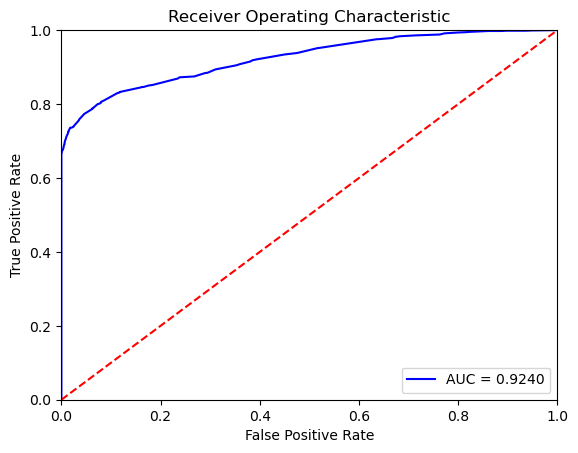

In [25]:
#Random Forest

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

rf_confusion_matrix = confusion_matrix(y_test,y_pred)
plot_confusion_matrix(rf_model,rf_confusion_matrix)

print("\nClassification Report:\n", classification_report(y_test, y_pred))

plot_roc_curve(rf_model,X_test,y_test)

In [9]:
from sklearn.model_selection import StratifiedKFold

# Define Stratified K-Fold Cross Validation
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Initialize variables to store results
cross_val_results = []

# Perform cross-validation
for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), start=1):
    # Split data into train and validation sets
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Train the Random Forest model
    rf_cv = RandomForestClassifier(n_estimators=100, random_state=fold)
    rf_cv.fit(X_train, y_train)
    
    # Calculate Train Accuracy
    train_accuracy = accuracy_score(y_train, rf_cv.predict(X_train))
    
    # Calculate Validation Accuracy
    val_accuracy = accuracy_score(y_val, rf_cv.predict(X_val))
    
    # Store results
    cross_val_results.append((fold, val_accuracy, train_accuracy))

# Display results in the desired format
formatted_cross_val_results = "\n".join([
    f"Fold {fold}: Validation Accuracy: {val_acc:.4f}, Train Accuracy: {train_acc:.4f}"
    for fold, val_acc, train_acc in cross_val_results
])

print(formatted_cross_val_results)

Fold 1: Validation Accuracy: 0.8750, Train Accuracy: 0.8656
Fold 2: Validation Accuracy: 0.8480, Train Accuracy: 0.8687
Fold 3: Validation Accuracy: 0.8600, Train Accuracy: 0.8678
Fold 4: Validation Accuracy: 0.8560, Train Accuracy: 0.8686
Fold 5: Validation Accuracy: 0.8780, Train Accuracy: 0.8664
Fold 6: Validation Accuracy: 0.8610, Train Accuracy: 0.8677
Fold 7: Validation Accuracy: 0.8690, Train Accuracy: 0.8671
Fold 8: Validation Accuracy: 0.8490, Train Accuracy: 0.8697
Fold 9: Validation Accuracy: 0.8490, Train Accuracy: 0.8692
Fold 10: Validation Accuracy: 0.8480, Train Accuracy: 0.8694
